# DTSA 5511 Introduction to Deep Learning Final Project

## Project Overview

Banks have been using machine learning to improve their customer interactions. Using “propensity to buy” models, they try to offer the right projects at the right time. The model outputs are used not only by sales agents and web sites, but also by the tellers and customer support agents as well as for direct mail distribution and for banner ads on the internet banking sites. As fewer customers are showing up at the branches, these models are becoming more critical for banks.

The models require frequent refreshment to avoid the performance degradation, and the automation of the model development process is important to keep the cost below the benefit.

I developed a few supervised models using the data mentioned below in a previous project. I observed decent model performance, but it required significant feature engineering and model tuning, and I was left with a feeling that it could still be improved. 

In this project, I adopted deep learning to see if it can reduce the model development load and improve the model performances.



## The Data

The data was downloaded from UCI Machine Learning Repository. The data source is stated as: 

`[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014`

The data was available in CSV format, accompanied by metadata definition files. It includes four data sets:  1) original version of 45,211 entries with 17 fields. 2) 10% sample of 4,521 entries from 1). 3) updated version of 41,188 entries with 20 fields. 4) 10% sample of 4119 entries from 3).  The smaller versions were provided to be less computing resource intensive in 2014. It is not much of an issue in 2022, and I only used the dataset 3).


In [1]:
# Import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Load the downlorded CSV data

df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=";")

## Data Cleaning Steps - Inspections

The interactive inspection below showed that the dataset contains 11 object, 5 float and 5 integer fields. First, I checked the distribution of the object fields to find out if they are categorical values (or something else), if they have irregular values, and if they show healthy distributions. 

Then I used boxplots to see the distributions of numeric fields.


---data type counts---
object     11
int64       5
float64     5
dtype: int64

---label counts---
y
no     36548
yes     4640
Name: age, dtype: int64

---object fields overview---
++++++++++++job+++++++++++++++++
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64
++++++++++++marital+++++++++++++++++
married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64
++++++++++++education+++++++++++++++++
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64
++++++++++++default+++++++++++++++++
no         3

<Figure size 2592x1728 with 0 Axes>

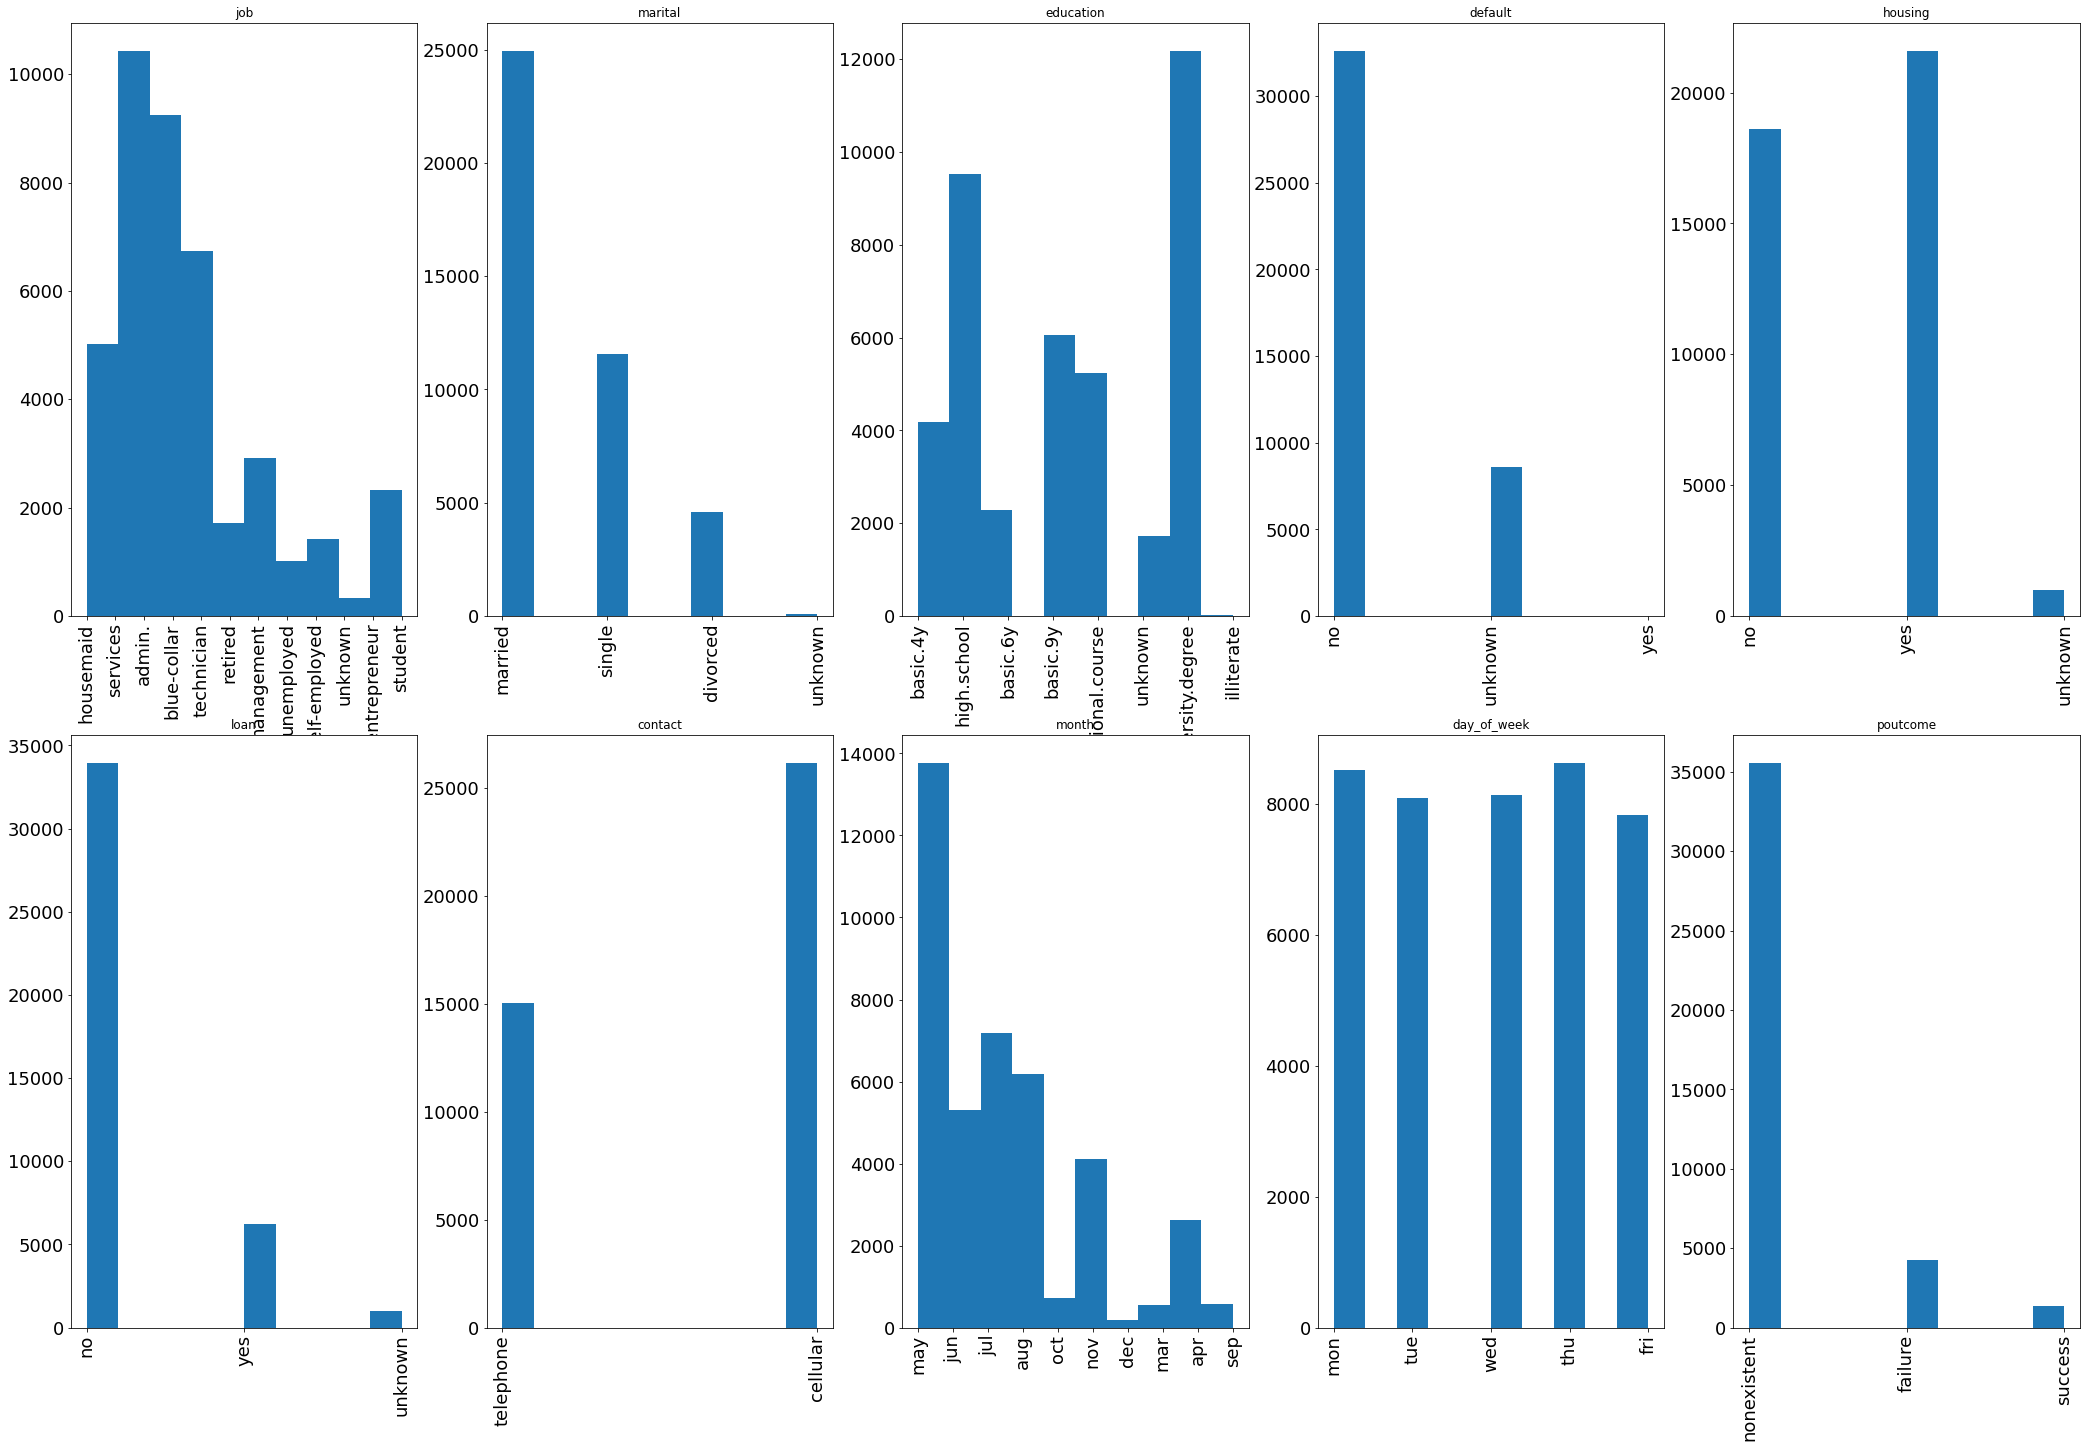

In [3]:
# Interactive investigations

print ("---data type counts---")
print (df.dtypes.value_counts())
print ("\n---label counts---")
print (df.groupby('y').count()['age'])

# Find out what those "object" fields are

print ("\n---object fields overview---")
for col in df.columns:
    if df[col].dtypes=='object' and col !='y':
        print (f"++++++++++++{col}+++++++++++++++++")
        print (df[col].value_counts())

nrows = 2
ncols = 5
row = 0
col = 0

fig = plt.figure(figsize=(36,24))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(36,24))

# Draw histograms

for c in df.columns:
    if df[c].dtypes=='object' and c !='y':
        axes[row][col].tick_params(axis='x',labelsize=18,labelrotation=90)
        axes[row][col].tick_params(axis='y',labelsize=18)
        axes[row][col].set_title(c)
        axes[row][col].hist(df[c])
        col = col + 1
        if col > 4:
            row = row + 1
            col = 0


<Figure size 2592x1728 with 0 Axes>

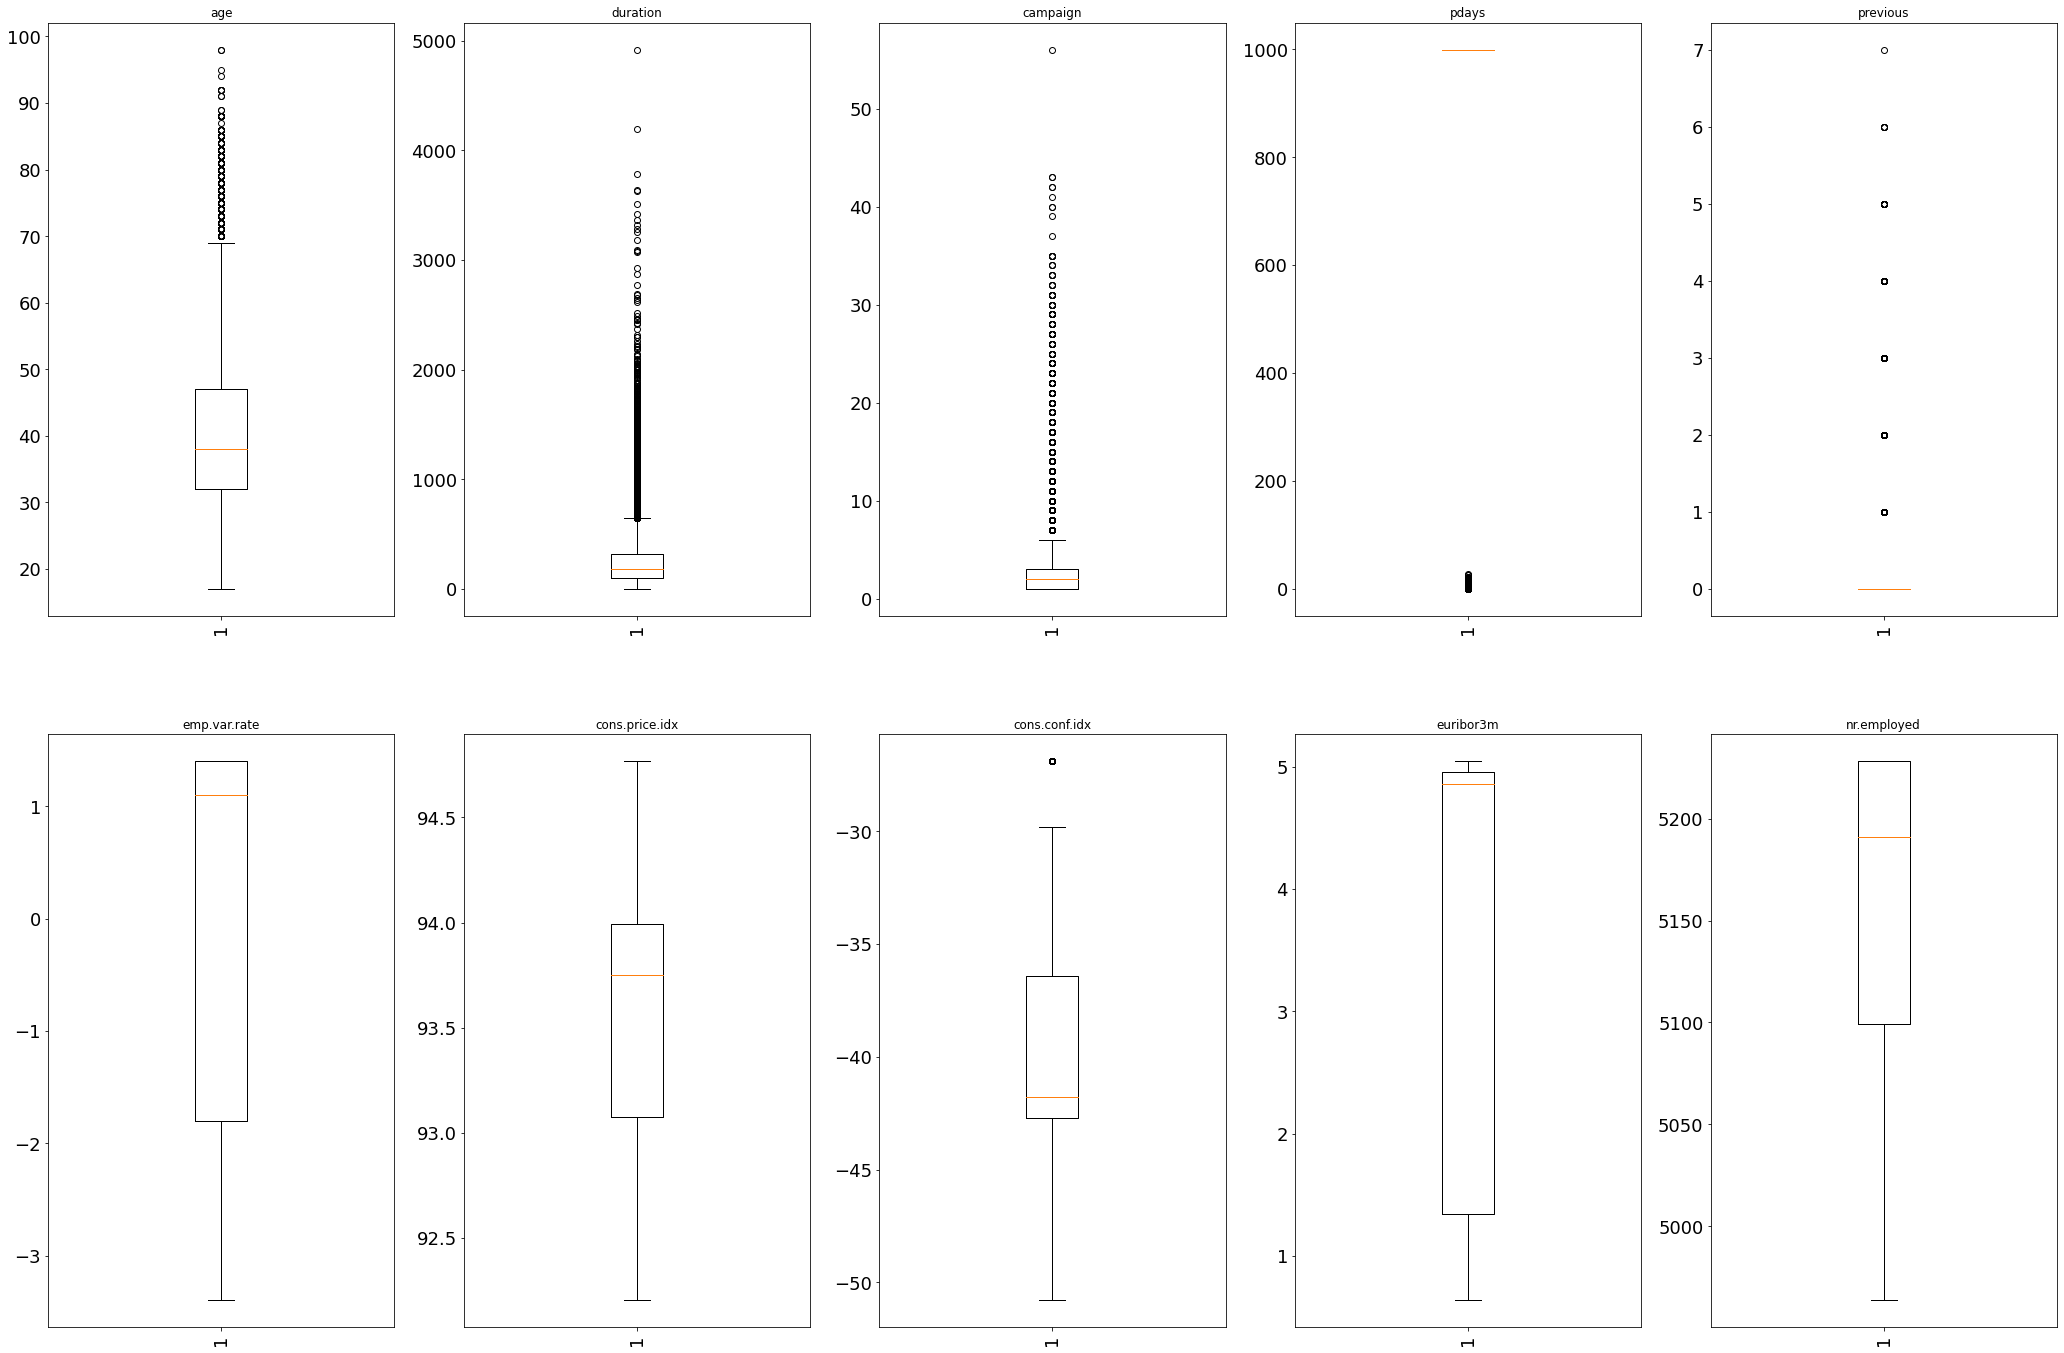

In [4]:
# Distrubition of numerical fields in boxplots

fig = plt.figure(figsize=(36,24))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(36,24))

row = col = 0
for c in df.columns:
    if df[c].dtypes in ['int64','float64']:
        axes[row][col].tick_params(axis='x',labelsize=18,labelrotation=90)
        axes[row][col].tick_params(axis='y',labelsize=18)
        axes[row][col].set_title(c)
        axes[row][col].boxplot(df[c])
        col = col + 1
        if col > 4:
            row = row + 1
            col = 0

plt.show()

## Data Cleanup Steps, continued

### Handling null values

The target variable y had 36,548 No values and 4,640 Yes values. 

All the object fields turned out to be categorical fields. Some categorical fields contained "unknown" values. Based on the distribution and correlations with the target variable (investigated interactively), I decided to process each field with “unknown” respectively as follows:

1.	job: “unknown” carries certain meaning and they should be in its own category
2.	martial: “unknown” had a response rate that was closest to "single" so replace it with "single."
3.	default: default is as in bankruptcy. As such “unknown” carries certain meaning and they should be in its own category
4.	housing: “unknown” is replaced with “No” since they are more likely not to have mortgage.
5.	loan: “unknown” is replaced with “Yes” since assuming existing loans would be safer.

I did not find NULL value from numeric fields.

### Handling outliers
1.	education==illiterate: It does not look like a proper value, and there were only 18 records. Those records were removed.
2.	default ==Yes: The records were very few, and they would be excluded from campaigns anyways. Those records were removed.
3.	campaign (number of past campaign participations): there were outliers up to 5SDs. They were floored down to be around to 3SDs.
4.	precious contact: Very few records had numbers greater than 1. Converted them to 1. 

Other categorical fields did not show any negligibly small values (less than 10% of the nearest values)

Other numerical fields’ max and min values are within the range of between -3SDs and +3SDs. 

### Removal of fields
I decided to remove the following fields from the models.
1.	postcome: Showing outcome from the previous campaign. Most likely they would not be included in the future campaign.
2.	duration: The call duration is not available beforehand.
3.	pdays : Days since the previous contact. Too skewed.

### Numerical conversion
Values of binary fields, such as with Yes/No values, were converted to 0 and 1.



In [5]:
# Data cleansing

# reload the source file for my convenience
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=";")

# martial.unkowns -> single
df['marital'] =  pd.Series(["single" if df['marital'][i] == 'unknown' else df['marital'][i] for i in range(len(df['marital']))])

# ignore education.illiterate
df = df[df.education != 'illiterate']
df.reset_index(inplace=True)

df = df[df['default'] != 'yes']
df.reset_index(inplace=True)

# Unknown values handling for housing and loan
df['housing'] =  pd.Series(["no" if df['housing'][i] == 'unknown' else df['housing'][i] for i in range(len(df['loan']))])
df['loan'] =  pd.Series(["yes" if df['loan'][i] == 'unknown' else df['loan'][i] for i in range(len(df['loan']))])

# Aggregate values for campaign and previous
df['campaign'] =  pd.Series([10 if df['campaign'][i] > 9 else df['campaign'][i] for i in range(len(df['campaign']))])
df['previous'] = pd.Series([1 if df['previous'][i] >=1 else 0 for i in range(len(df['previous']))])

df.drop(['level_0','index'], axis=1, inplace=True)

# Drop unnecessary columns
df. drop(['poutcome','duration','pdays'],axis=1, inplace=True)

# Convert binary columns to {0,1}, including the target column (y)
df['default'] =  pd.Series([1 if df['default'][i] == 'unknown' else 0 for i in range(len(df['default']))])

df['housing'] =  pd.Series([1 if df['housing'][i] == 'yes' else 0 for i in range(len(df['housing']))])
df['loan'] =  pd.Series([1 if df['loan'][i] == 'yes' else 0 for i in range(len(df['loan']))])
df['contact'] =  pd.Series([1 if df['contact'][i] == 'cellular' else 0 for i in range(len(df['contact']))])

df['y'] =  pd.Series([1 if df['y'][i] == 'yes' else 0 for i in range(len(df['y']))])


## Exploratory Data Analysis

The values of "months" and "week" fields affected the response rates, but the patterns are not in order as shown in the charts below. As such, I calculated the response rate for each month and week, and replace the week and the month with the respective response rate.

After converting the categorical fields into indicator fields using `pandas.getdummies()`, I generated the heatmap for the correlations. It showed some strong correlations between some predictor variables, but not strong correlations toward the target variable.



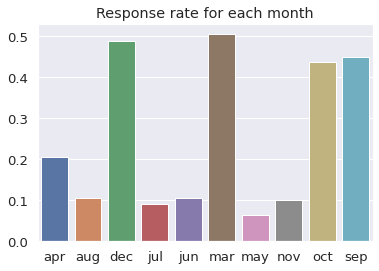

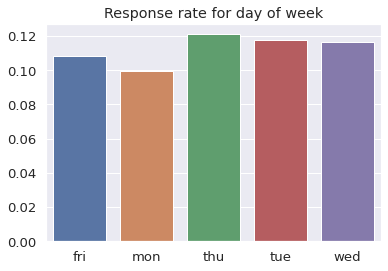

In [191]:
month_sums = {}  # {'month':(positive, total)}
for ind in df.groupby(['month','y']).count()['age'].index:
    month = ind[0]
    val= ind[1]
    cnt = df.groupby(['month','y']).count()['age'].get(ind)
    
    if (month in month_sums):
        pos = month_sums[month][0]
        tot = month_sums[month][1]
        month_sums[month] = (pos+val*cnt, tot+cnt)
    else:
         month_sums[month] = (val*cnt, cnt)

# create a dictionary for the ratio
monthly_ratio = {}
for key in month_sums:
    monthly_ratio[key] = month_sums[key][0]/ month_sums[key][1]
    
# Draw a chart

vec_x = [k for k in monthly_ratio.keys()]
vec_y = [monthly_ratio[k] for k in vec_x]

sns.set(font_scale=1.2)
sns.barplot(x=vec_x, y=vec_y).set_title("Response rate for each month")
plt.show()

# Replace
df['month'] =  pd.Series([monthly_ratio[df['month'][i]] for i in range(len(df['month']))])

week_sums = {}  # {'month':(positive, total)}
for ind in df.groupby(['day_of_week','y']).count()['age'].index:
    week = ind[0]
    val= ind[1]
    cnt = df.groupby(['day_of_week','y']).count()['age'].get(ind)
    if (week in week_sums):
        pos = week_sums[week][0]
        tot = week_sums[week][1]
        week_sums[week] = (pos+val*cnt, tot+cnt)
    else:
        week_sums[week] = (val*cnt, cnt)

# create a dictionary for the ratio
weekly_ratio = {}
for key in week_sums:
    weekly_ratio[key] = week_sums[key][0]/ week_sums[key][1]
    
# Draw another chart for the day of the week

vec_x = [k for k in weekly_ratio.keys()]
vec_y = [weekly_ratio[k] for k in vec_x]

sns.set(font_scale=1.2)
sns.barplot(x=vec_x, y=vec_y).set_title("Response rate for day of week")
plt.show()

# Replace
df['day_of_week'] =  pd.Series([weekly_ratio[df['day_of_week'][i]] for i in range(len(df['day_of_week']))])


Text(0.5, 1.0, 'Correlation heatmap')

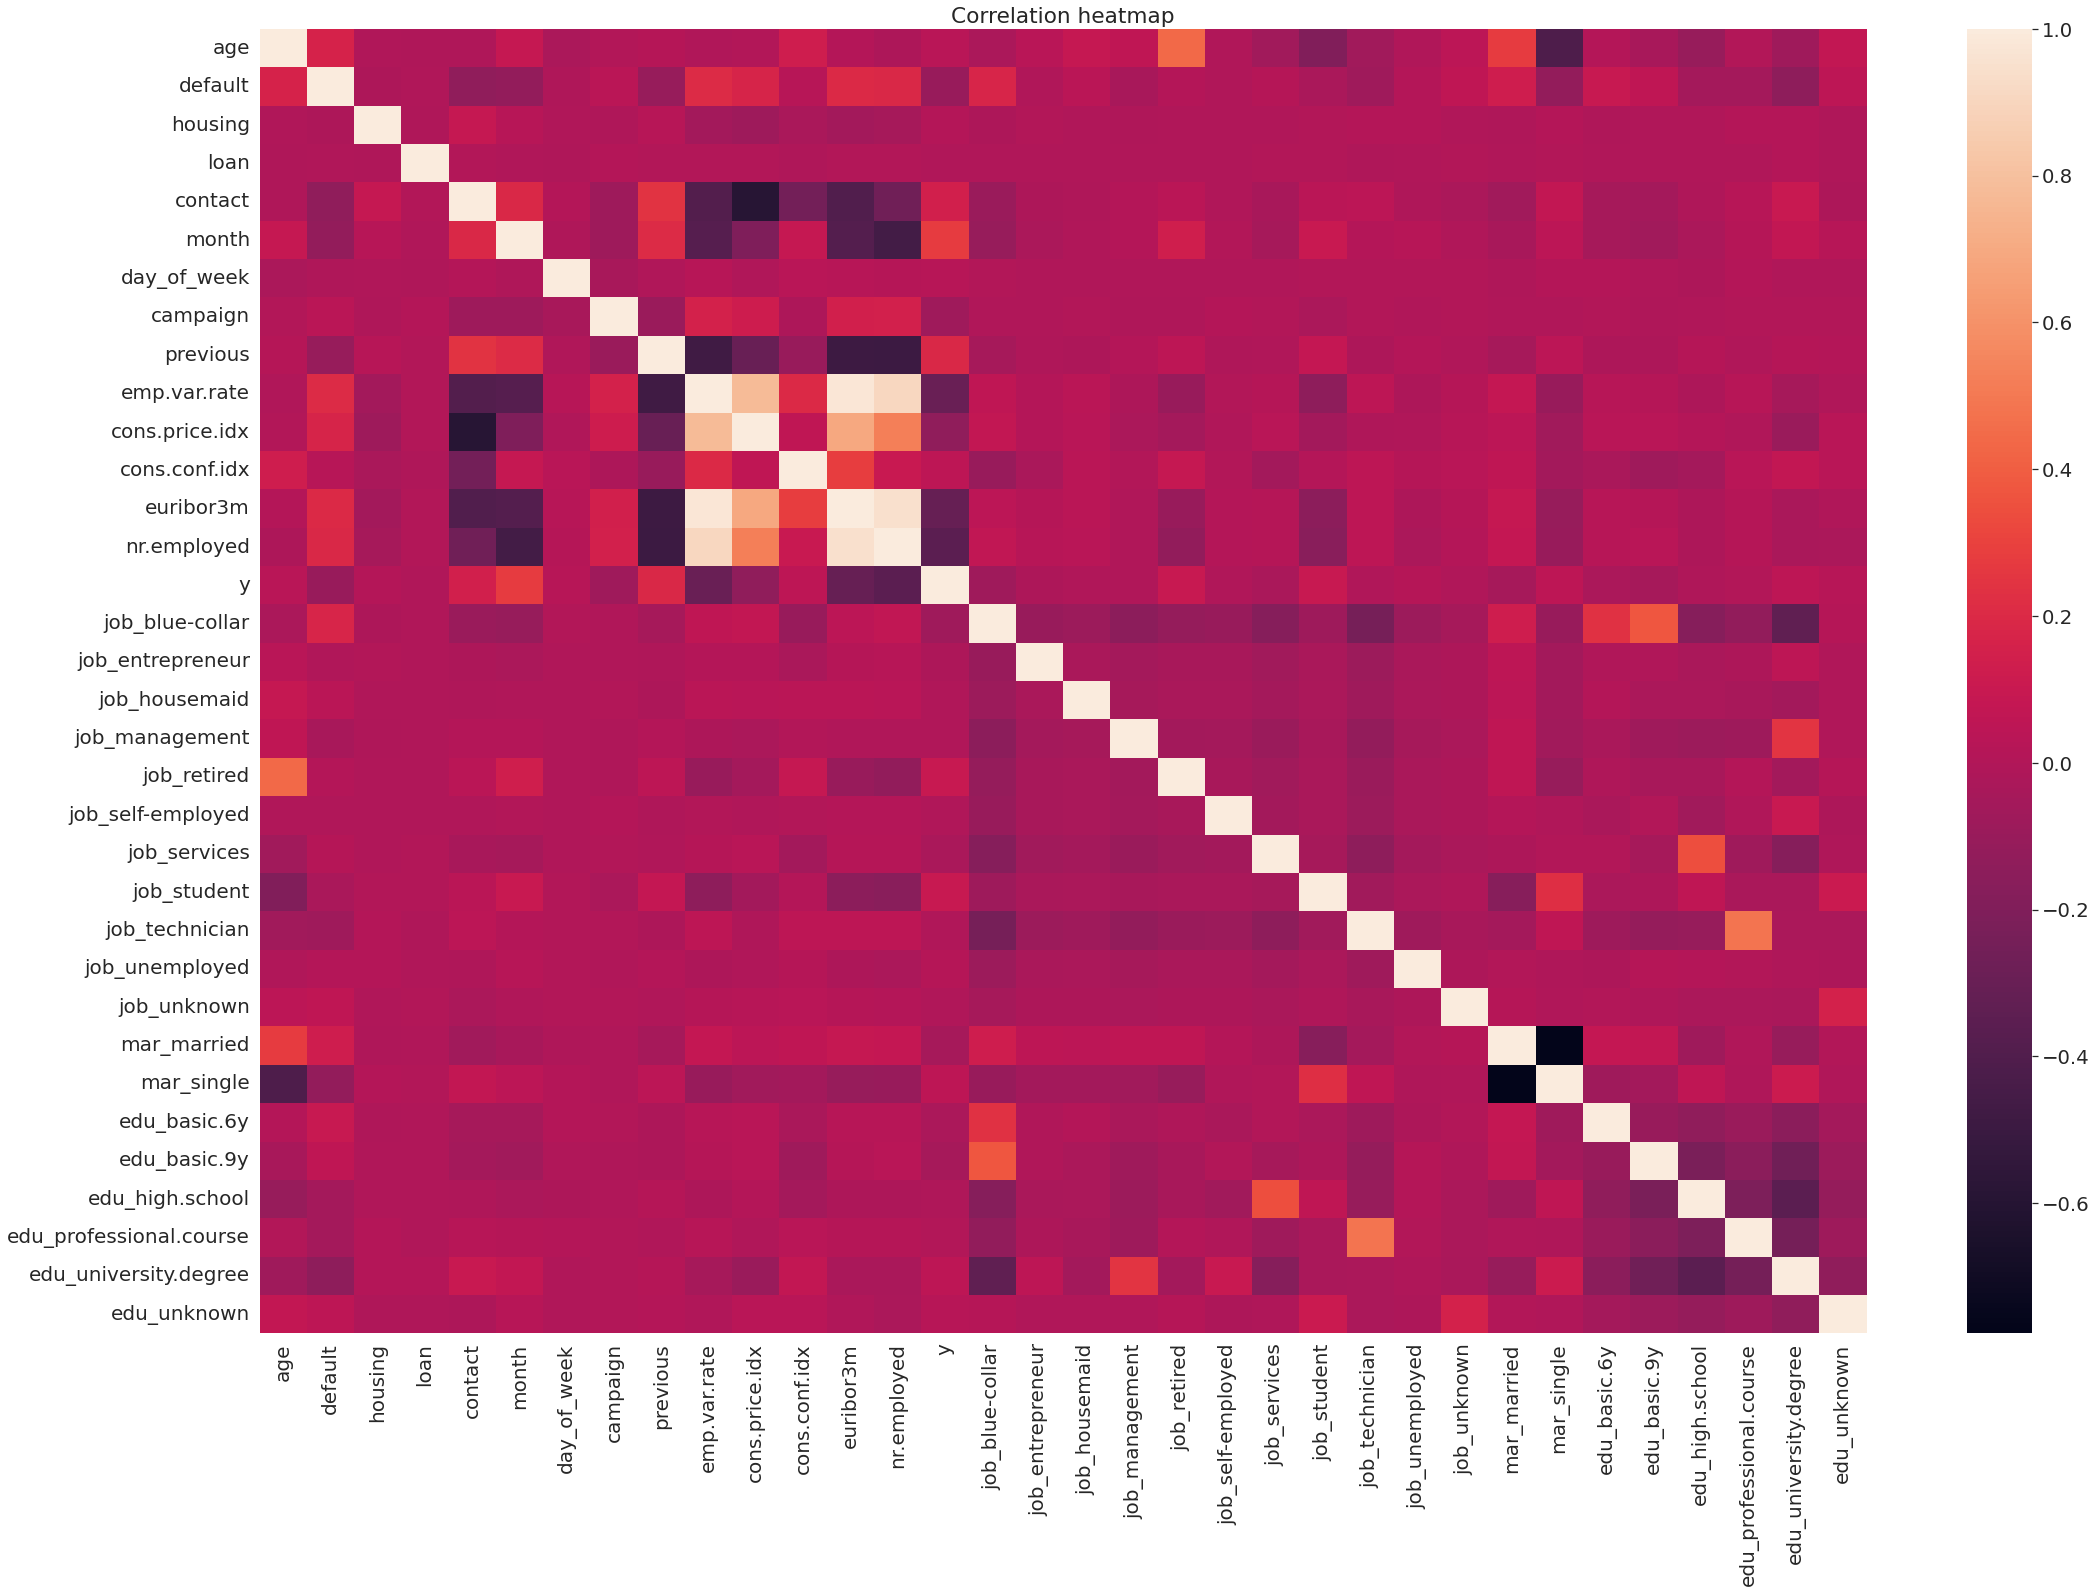

In [192]:
# Convert categorical data to index fields

df = pd.concat([df, pd.get_dummies(df['job'], drop_first=True, prefix='job')], axis=1)
df.drop('job',axis=1, inplace=True)

df = pd.concat([df, pd.get_dummies(df['marital'], drop_first=True, prefix='mar')], axis=1)
df.drop('marital',axis=1, inplace=True)

df = pd.concat([df, pd.get_dummies(df['education'], drop_first=True, prefix='edu')], axis=1)
df.drop('education',axis=1, inplace=True)

fig = plt.figure(figsize=(36,24))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

sns.set(font_scale=1.8)
sns.heatmap(df.corr()).set_title("Correlation heatmap")

## Exploratory Data Analysis Continued
To detect collinearity, I computed VIF for all the fields. Initially 5 fields showed greater than 10 VIF. After some experiments, I found that removing euribor3m and emp.var.rate will make all the VIF values less than 10. I concluded those two fields had collinearity and should be removed from the model. 

Then I generated a heatmap and a barchart for correlations.

Intuitively, none of the fields had strong correlation with the target variable, which calls for multivariable models. 


Text(0.5, 1.0, 'Correlations to the target')

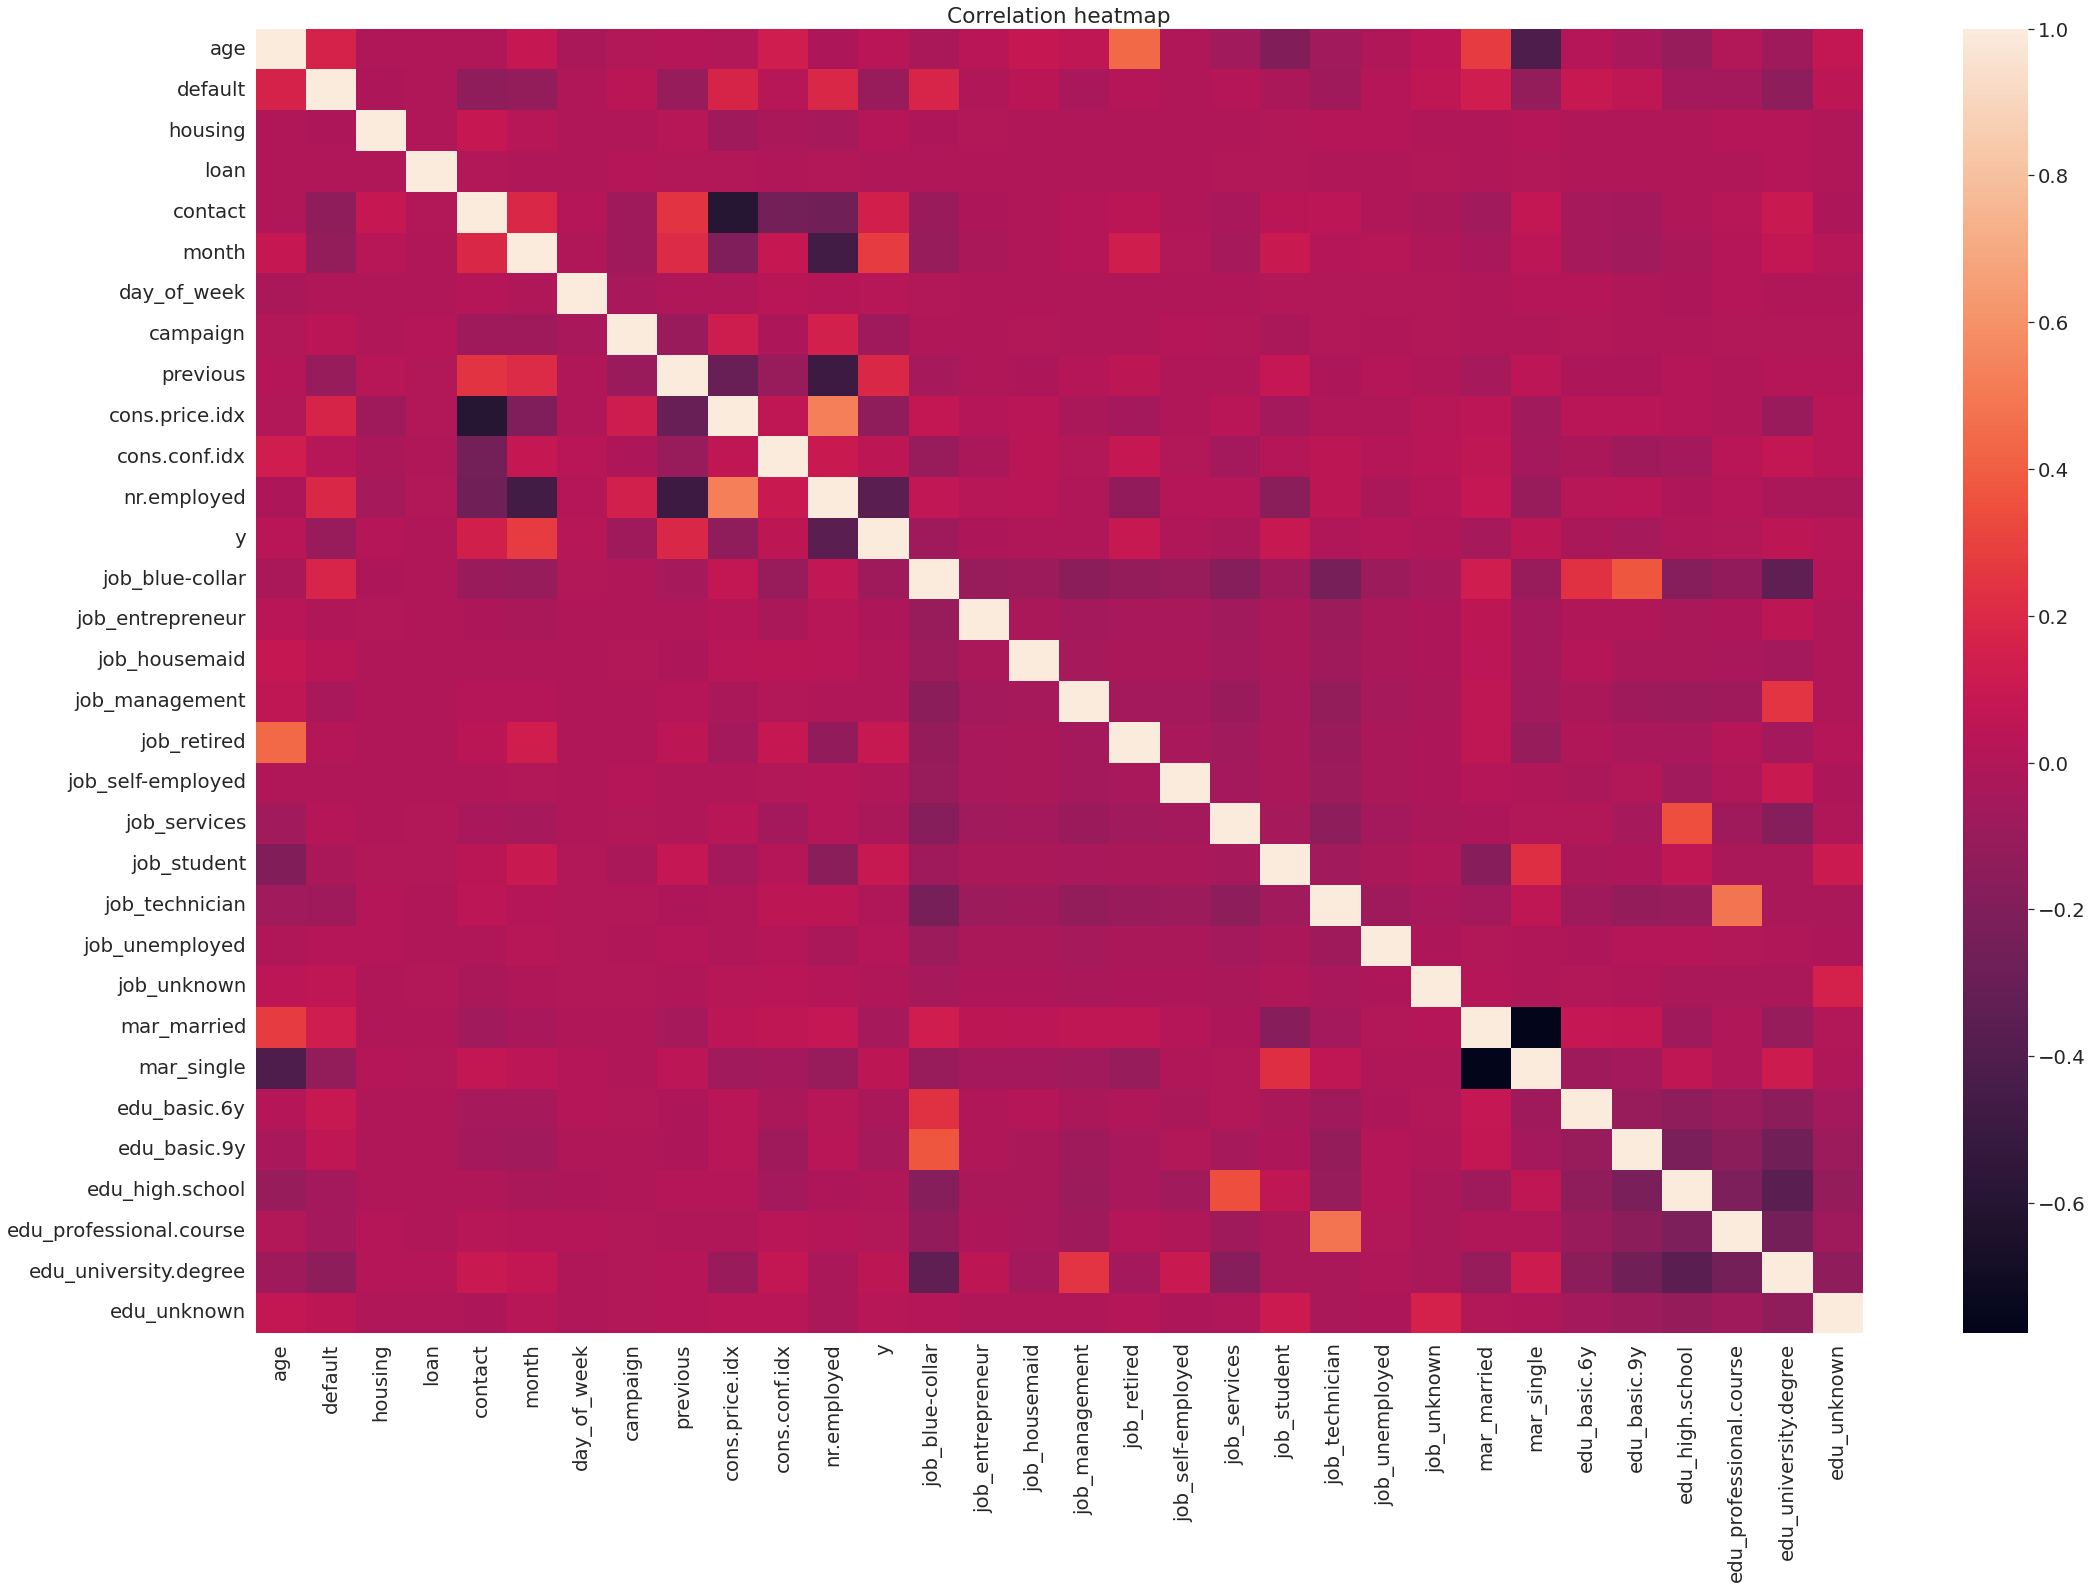

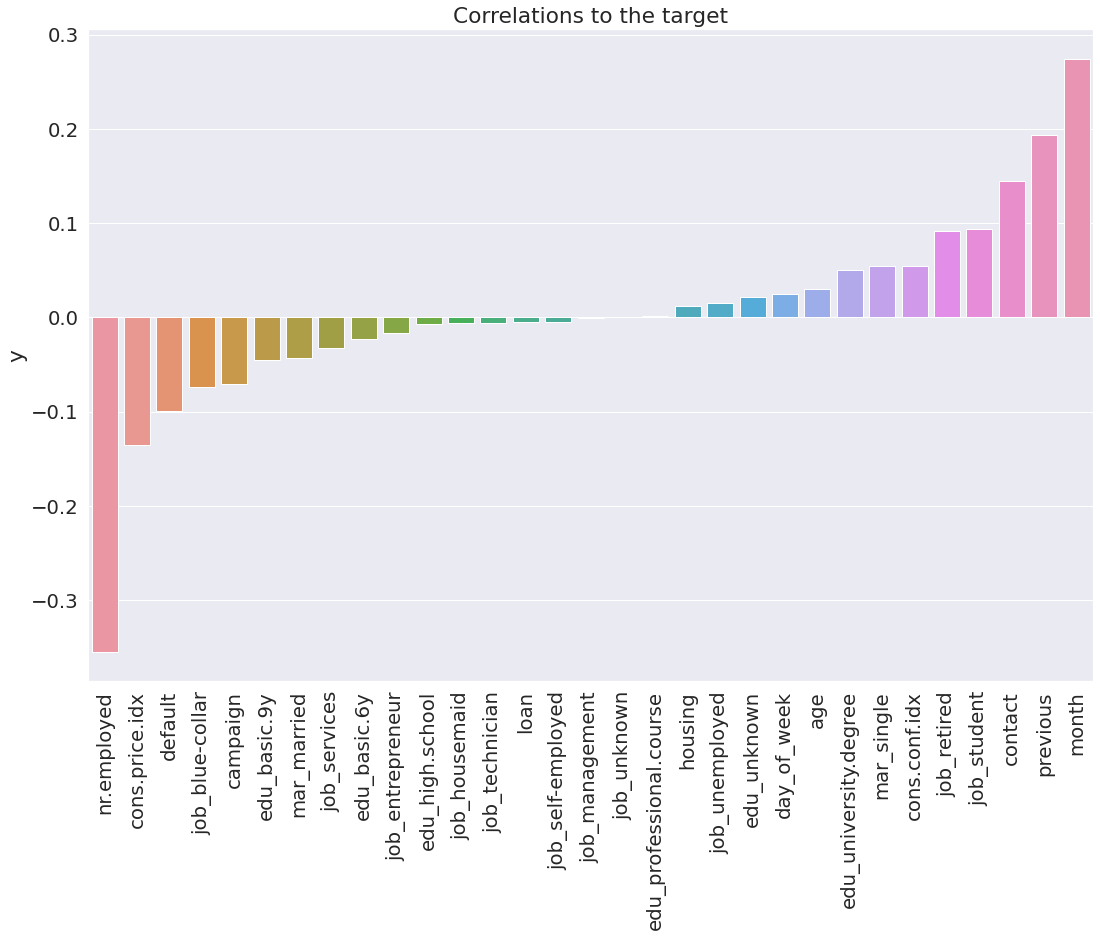

In [193]:
# VIF and tolerance computation

from sklearn.linear_model import LinearRegression 
vif, tolerance = {}, {}
   
for feature in df.columns:
    xx = [f for f in df.columns if f not in [feature,'y','euribor3m','emp.var.rate']]   # remove those two.

    xx, yy = df[xx], df[feature]
    r2 = LinearRegression().fit(xx, yy).score(xx, yy)                
    tolerance[feature] = 1 - r2
    vif[feature] = 1/(tolerance[feature])

df.drop(['euribor3m','emp.var.rate'],axis=1,inplace=True)
fig = plt.figure(figsize=(36,24))
sns.set(font_scale=1.8)

sns.heatmap(df.corr()).set_title("Correlation heatmap")

fig = plt.figure(figsize=(18,12))
plt.xticks(rotation=90)

sns.barplot(x=df.corr().sort_values(by='y',axis=0)['y'][:-1].index,y=df.corr().sort_values(by='y')['y'][:-1]).set_title("Correlations to the target")

## Supervised Models
These are the results from traditional supervised models. After scaling the prepared data, I split them to 70% training and 30% test, and then trained a number of models, and I kept logistic regression and random forest as representing traditional models.

Both models went through significant feature engineering, cross validation, collineality control and hyperparameter tuning to achieve the shown results. With the accuracy scores of almost 90% and close-to 0.8 AUC, the overall performances were acceptable.  But the recall rate for y=1, which matters most for banks’ business, was not spectacular at around 21%. It is showing significant (86%) improvement from the population response rate of 11.3%, but I would expect larger improvement. In fact, I noted at the conclusion of the previous project that I would try to improve the recall rate in the future.



-----------------CV Logistic Regression---------------
Classification Report

              precision    recall  f1-score   support

           0       0.91      0.97      0.94     10953
           1       0.52      0.21      0.30      1398

    accuracy                           0.89     12351
   macro avg       0.71      0.59      0.62     12351
weighted avg       0.86      0.89      0.87     12351

Confusion Matrix

[[10677   276]
 [ 1102   296]]

accuracy score 0.8884300866326613


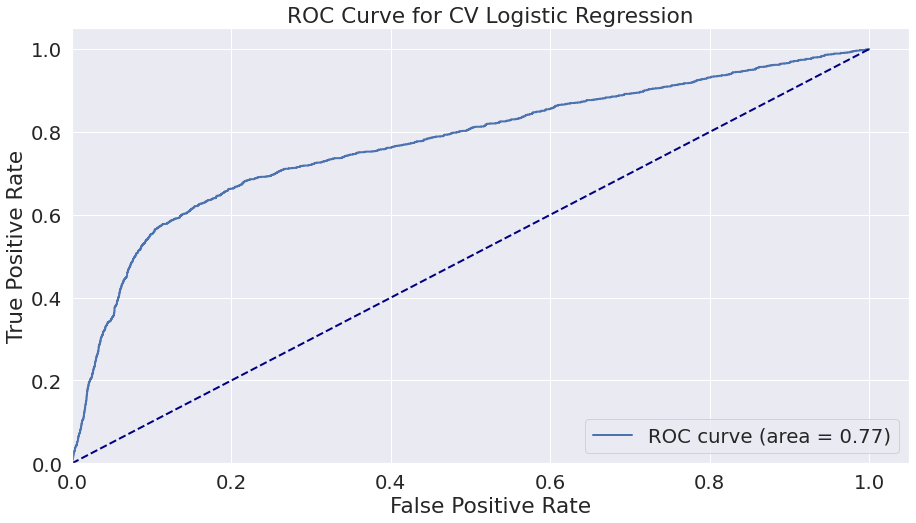

-----------------Random Forest---------------
Classification Report

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     10953
           1       0.59      0.21      0.31      1398

    accuracy                           0.89     12351
   macro avg       0.75      0.60      0.63     12351
weighted avg       0.87      0.89      0.87     12351

Confusion Matrix

[[10749   204]
 [ 1104   294]]

accuracy score 0.8940976439154724


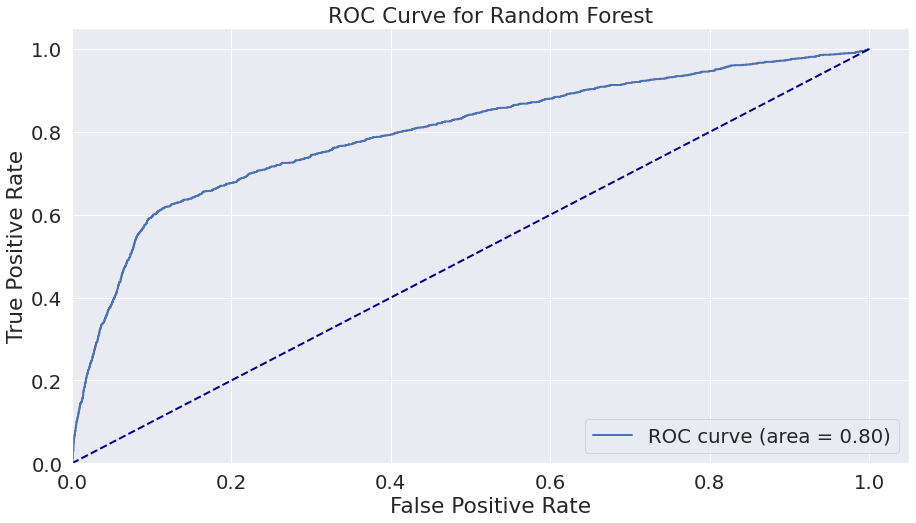

In [195]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils.random import sample_without_replacement
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

def classification_printout(title,y_test, pred_bin, predictions):
    print (f"-----------------{title}---------------")
    print('Classification Report\n')
    print(classification_report(y_test,pred_bin))
    print('Confusion Matrix\n')
    print(confusion_matrix(y_test,pred_bin))
    print(f'\naccuracy score {accuracy_score(y_test,pred_bin)}')
    
    fpr, tpr, _ = roc_curve(y_true=y_test, y_score=predictions)
    roc_auc = roc_auc_score(y_test, predictions)

    plt.figure(figsize=(15,8))
    lw=2
    plt.plot(fpr,tpr,lw=lw,label="ROC curve (area = %0.2f)" % roc_auc)

    zz = zip(fpr, tpr)
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0, 1.05])
    plt.ylim([0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {title}")
    plt.legend(loc="lower right")
    plt.show()
        
scaler = StandardScaler()
scaler.fit(df.drop('y',axis=1))

# X and Y scale

X = pd.DataFrame(scaler.transform(df.drop('y',axis=1)), columns=df.columns.drop("y"))
Y = df['y']

## Split the test data 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state=231) # 0.25/11

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

# CV Logistic Regerssions

clf = LogisticRegressionCV(cv=5, random_state=0).fit(X_train, y_train)

pred_bin = clf.predict(X_test)
predictions = clf.decision_function(X_test)
classification_printout("CV Logistic Regression", y_test, pred_bin, predictions)


# Random Forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=800, max_depth=10,min_samples_leaf=12 )
rfc.fit(X_train,y_train)

pred_bin = rfc.predict(X_test)
predictions = rfc.predict_proba(X_test)[:,1]
classification_printout("Random Forest",y_test,pred_bin,predictions)


## First Deep Learning Model
As the first step, I built an artificial neural network model using TensorFlow/Kera. I trained and validated the model using the same input data that I used for the supervised models. 

The model is a sequential neural network consisting of the input layer, two hidden layers, and the output layer. The numbers of units are aligned to the number of parameters, and set to 31, 62, 16 and 1 respectively. The activation functions are set to ReLU except for the output layer which uses Sigmoid.

I added a Dropout to the first hidden layer to avoid overfitting in that layer. 

The below is showing the outcome from the 30 epochs training. The learning curve shows healthy progression, and the result is comparable, or slightly better than other supervised models. Considering that I applied substantial tuning to those supervised models, we can see the power of the deep learning already.

At the same time, the fact they are all showing the similar results suggests that the data might be almost fully explained by those models. Let’s see how much more deep learning can deliver.


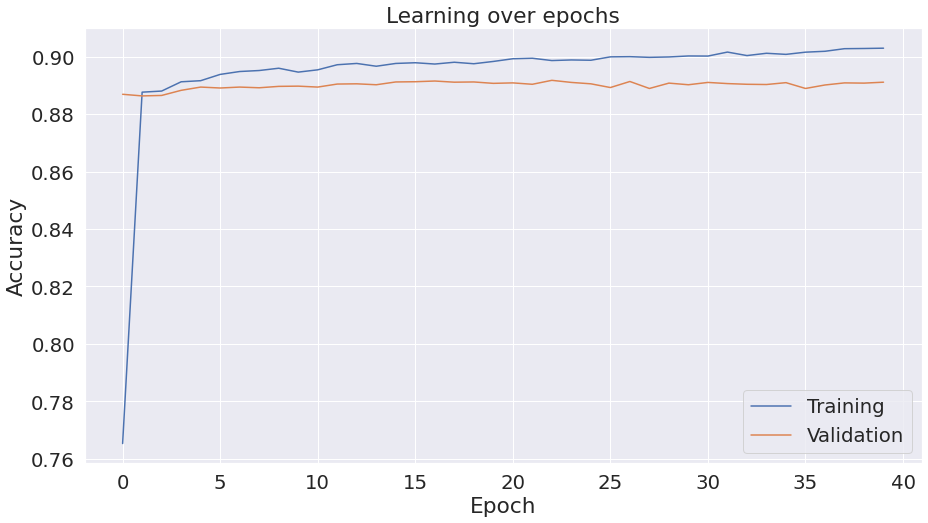

-----------------Deep Learning---------------
Classification Report

              precision    recall  f1-score   support

           0       0.91      0.97      0.94     10953
           1       0.54      0.24      0.33      1398

    accuracy                           0.89     12351
   macro avg       0.73      0.61      0.64     12351
weighted avg       0.87      0.89      0.87     12351

Confusion Matrix

[[10673   280]
 [ 1065   333]]

accuracy score 0.8911019350659866


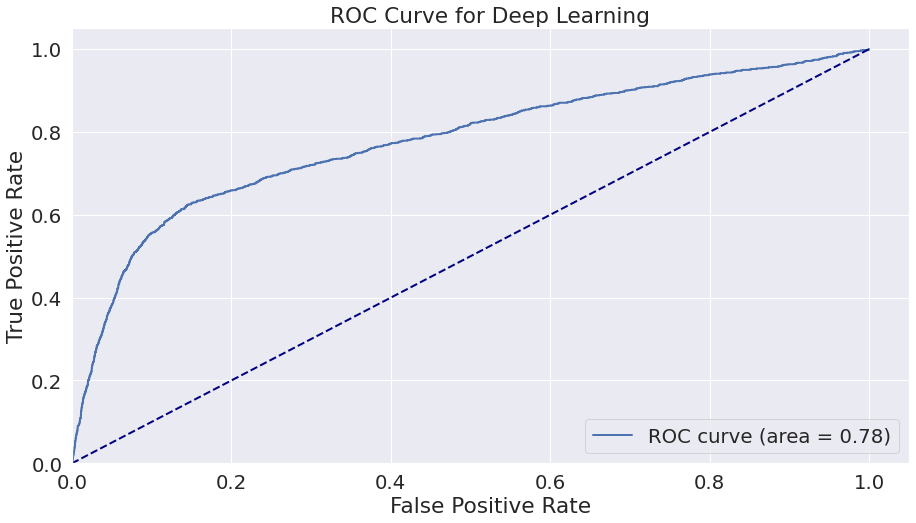

In [200]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm

model = Sequential()

# input layer
model.add(Dense(31,  activation='relu'))

# hidden layer
model.add(Dense(48, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, activation='relu'))

# output layer
model.add(Dense(units=1,activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

history = model.fit(x=X_train, 
          y=y_train, 
          epochs=40,
          batch_size=256,
          validation_data=(X_test, y_test), 
          verbose=0
          )

plt.figure(figsize = (15,8))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Training", "Validation"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Learning over epochs")
plt.show()

predictions = model.predict(X_test, verbose=0)
pred_bin = predictions.round().astype(int)

classification_printout("Deep Learning",y_test,pred_bin,predictions)


## Deep Learning Model Without Feature Engineering
While I observed some improvements with hyperparameter tuning, one of the expectations deep learning models is automation. The next model was trained without major feature engineering, and it was given all the categorical values as indicator variables too. Therefore, the model development time was kept minimum.

It performed better than all the previous models. Although the learning curve shows a sign of overfitting, it achieved a better recall rate with a similar accuracy score. 

With this performance and productivity, we can claim that deep learning model is more suitable for this purpose. 

Note that the data does not show strong correlations between the predictors and the response. Thus it was not surprising traditional models required significant turning to obtain decent performance. 

Deep learning models appear to function better under the circumstance where the correlations from the predictors are not very strong. This also suggests that there will be an issue of expandability, though. It would be good for a marketing model like this, but something to consider for things like credit approval or any human related models.


In [6]:
# Data load, data cleansing and minimum feature engineering

# reload the source file for my convenience
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=";")

# Drop unnecessary columns
df. drop(['poutcome','duration','pdays'],axis=1, inplace=True)

# Convert binary columns to {0,1}, including the target column (y)
df['default'] =  pd.Series([1 if df['default'][i] == 'unknown' else 0 for i in range(len(df['default']))])

df['housing'] =  pd.Series([1 if df['housing'][i] == 'yes' else 0 for i in range(len(df['housing']))])
df['loan'] =  pd.Series([1 if df['loan'][i] == 'yes' else 0 for i in range(len(df['loan']))])
df['contact'] =  pd.Series([1 if df['contact'][i] == 'cellular' else 0 for i in range(len(df['contact']))])

df['y'] =  pd.Series([1 if df['y'][i] == 'yes' else 0 for i in range(len(df['y']))])

# Convert categorical data to index fields

df = pd.concat([df, pd.get_dummies(df['job'], drop_first=True, prefix='job')], axis=1)
df.drop('job',axis=1, inplace=True)

df = pd.concat([df, pd.get_dummies(df['marital'], drop_first=True, prefix='mar')], axis=1)
df.drop('marital',axis=1, inplace=True)

df = pd.concat([df, pd.get_dummies(df['education'], drop_first=True, prefix='edu')], axis=1)
df.drop('education',axis=1, inplace=True)

df = pd.concat([df, pd.get_dummies(df['month'], drop_first=True, prefix='month')], axis=1)
df.drop('month',axis=1, inplace=True)

df = pd.concat([df, pd.get_dummies(df['day_of_week'], drop_first=True, prefix='dow')], axis=1)
df.drop('day_of_week',axis=1, inplace=True)

from sklearn.utils.random import sample_without_replacement
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout,BatchNormalization
from tensorflow.keras.constraints import max_norm

def train_model (df=None, model_sel=1, training_adj_factor=4, units_multiplier=1, verbose=1, epochs=20):

# Reduce the number of "negative" records
    df_y=df[df['y']==1]
    df_n=df[df['y']==0].reset_index()
    sample = sample_without_replacement(len(df_n), len(df_n)/training_adj_factor)
    df_n = df_n.iloc[sample]
    df = pd.concat([df_y,df_n], axis=0).reset_index()

# Scale the variables    
    scaler = StandardScaler()
    scaler.fit(df.drop('y',axis=1))

    X = pd.DataFrame(scaler.transform(df.drop('y',axis=1)), columns=df.columns.drop("y"))
    X.drop(['level_0', 'index'],axis=1,inplace=True)
    Y = df['y']
    


## Split the test data 
    X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state=231) # 0.25/11

    model = Sequential()

    if model_sel==1:
        # input layer

        model.add(Dense(46*units_multiplier, activation='relu'))

        # hidden layer
        model.add(Dense(138*units_multiplier, activation='relu'))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())
        
        model.add(Dense(92*units_multiplier, activation='relu'))
        model.add(Dropout(0.1))
        
        model.add(Dense(24*units_multiplier, activation='relu'))
        #model.add(Dropout(0.2))

        model.add(Dense(10*units_multiplier, activation='relu'))
        # output layer
        model.add(Dense(units=1,activation='sigmoid'))
    else:
        # input layer

        model.add(Dense(46*units_multiplier, activation='relu'))

        # hidden layer
        model.add(Dense(23*units_multiplier, activation='relu'))
        model.add(Dropout(0.1))
        model.add(BatchNormalization())

        model.add(Dense(10, activation='relu'))
        model.add(BatchNormalization())
        
        # output layer
        model.add(Dense(units=1,activation='sigmoid'))

    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    history = model.fit(x=X_train, 
          y=y_train, 
          epochs=epochs,
          batch_size=128,
          validation_data=(X_test, y_test), 
          verbose=verbose
          )
    predictions = model.predict(X_test, verbose=0)
    return (model,history,predictions,y_test)

def calc_metrics(model,predictions,y_test):
    
# calculate accuracy and recall for positive
    pred = predictions.round().astype(int)
    c = confusion_matrix(y_test,pred)
    recall_1 = c[1,1]/sum(c[1,:])
    accu = accuracy_score(y_test,pred)
    return (accu, recall_1)


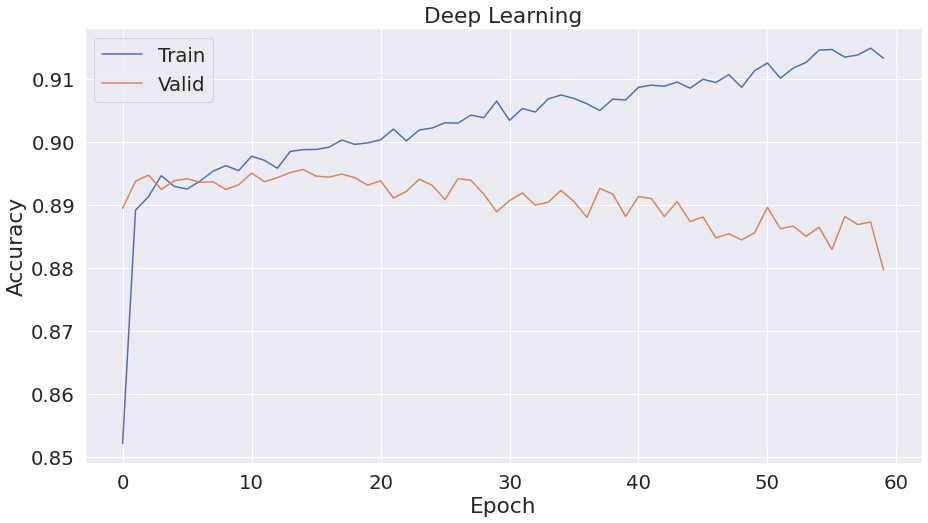

-----------------Deep Learning---------------
Classification Report

              precision    recall  f1-score   support

           0       0.92      0.95      0.93     10993
           1       0.44      0.33      0.38      1364

    accuracy                           0.88     12357
   macro avg       0.68      0.64      0.66     12357
weighted avg       0.87      0.88      0.87     12357

Confusion Matrix

[[10419   574]
 [  913   451]]

accuracy score 0.8796633487092337


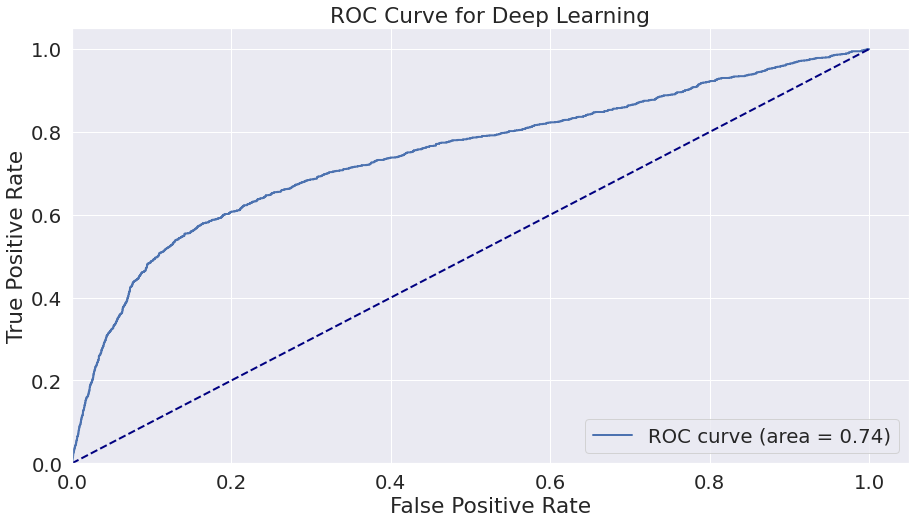

In [170]:
(model, history, predictions,y_test) = train_model(df=df, verbose=0, epochs=60, units_multiplier=1, model_sel=1, training_adj_factor=1)
# This is the best. Keep it.
plt.figure(figsize = (15,8))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Train", "Valid"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Deep Learning")
plt.show()

pred_bin = predictions.round().astype(int)
classification_printout("Deep Learning",y_test,pred_bin,predictions)

## Model Variations and Hyperparameter Tuning
To compare multiple deep learning models and to run hyperparameter turning, I wrote the following code to build a few combinations of models and hyperparameters. I prepared two artificial neural network models – one with mode hidden layers and aggressive dropouts, and another with fewer hidden layers and with normalizations. Then I supplied various number of units in each layer and the number of epochs for the training.

The chart shows the result. Overall, the model 1 showed preferable results. Model 2 achieved better accuracy scores, but it missed more y=1 records, or showed lower recall rate. It means model 1’s structure provides a more suitable learning mechanism for this purpose.

Also, with fewer number of units in layers showed more tendency of overfitting. This was counterintuitive to me, but for the data with less correlated predictors, I suspect that certain level of complexity of the neural network is required to capture the subtle patterns.

As for the epoch numbers, with the largest epochs (30), the plots are shifted to the right, meaning they achieved the higher accuracy. It suggests it was not affected by overfitting. Considering the scattered outcomes with epochs=10 and 20, epochs=30 is appropriate for this model and data.


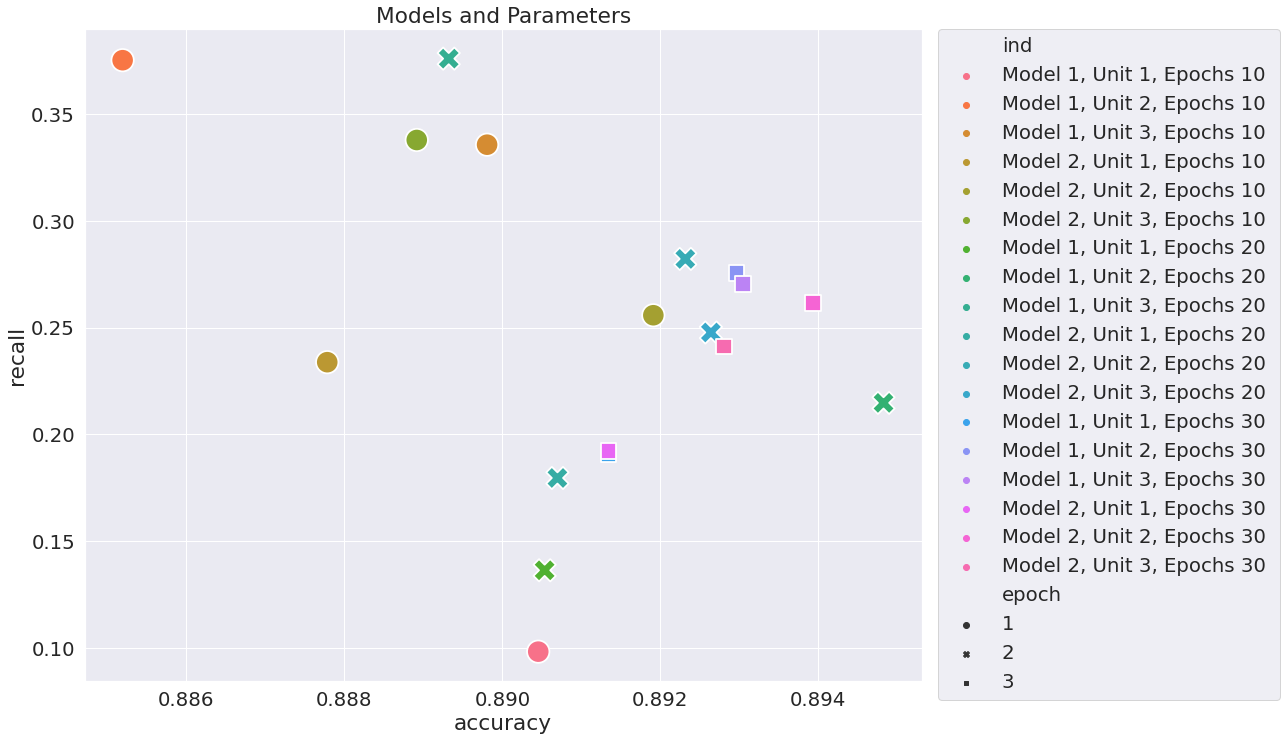

In [204]:
# [model,unit_multi,traiing_adj]
design_matrix=[[1,1,1],[1,2,1],[1,3,1],[2,1,1],[2,2,1],[2,3,1],[1,1,2],[1,2,2],[1,3,2],[2,1,2],[2,2,2],[2,3,2],
               [1,1,3],[1,2,3],[1,3,3],[2,1,3],[2,2,3],[2,3,3]]
labels = []
accuracy = []
recall = []
epoch = []
for dm in design_matrix:
    (model,history,predictions,y_test)=train_model(df=df, 
                            verbose=0, epochs=dm[2], units_multiplier=dm[1], model_sel=dm[0],training_adj_factor=1)
    output = calc_metrics(model,predictions,y_test)
    labels.append(f"Model {str(dm[0])}, Unit {str(dm[1])}, Epochs {str(dm[2]*10)} ")
    accuracy.append(output[0])
    recall.append(output[1])
    epoch.append(str(dm[2]))

chart = pd.DataFrame({"ind":labels, "accuracy":accuracy, "recall":recall, "epoch":epoch})

plt.figure(figsize = (15,12))
sns.scatterplot(data=chart, x='accuracy',y='recall',hue='ind',style='epoch',s=500)
plt.title("Models and Parameters")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [205]:
chart

,ind,accuracy,recall,epoch
0,"Model 1, Unit 1, Epochs 10",0.890454,0.098240,1
1,"Model 1, Unit 2, Epochs 10",0.885191,0.375367,1
2,"Model 1, Unit 3, Epochs 10",0.889806,0.335777,1
3,"Model 2, Unit 1, Epochs 10",0.887782,0.233871,1
4,"Model 2, Unit 2, Epochs 10",0.891912,0.255865,1
5,"Model 2, Unit 3, Epochs 10",0.888916,0.337977,1
6,"Model 1, Unit 1, Epochs 20",0.890535,0.136364,2
7,"Model 1, Unit 2, Epochs 20",0.894826,0.214809,2
8,"Model 1, Unit 3, Epochs 20",0.889321,0.376100,2
9,"Model 2, Unit 1, Epochs 20",0.890697,0.179619,2


## Model Validation with Various Input Data
At this point, I have to conclude the recall rate of 30% is almost as good as we can get, using the given data. One of the reasons is that because the loss function is designed to evaluate the overall “rightness,” the model tends to give more weights to more populous group, y=0 in this case.

I supplied some skewed sample data to train the models next. I reduced the number of y=0 records by 50% and 75% and see if the models pick up more y=1 data and intentional sampling. This may be a questionable practice, but as shown below, they yielded the expected results, which is much better recall rate for the price of overall predictive accuracy. It requires careful validation and selection of the validation data, but this could be useful in real world business operation. In this scenario, model 2 performed similarly to model 1, suggesting the balanced data does not require complex neural network as much as skewed data, which intuitively makes sense.



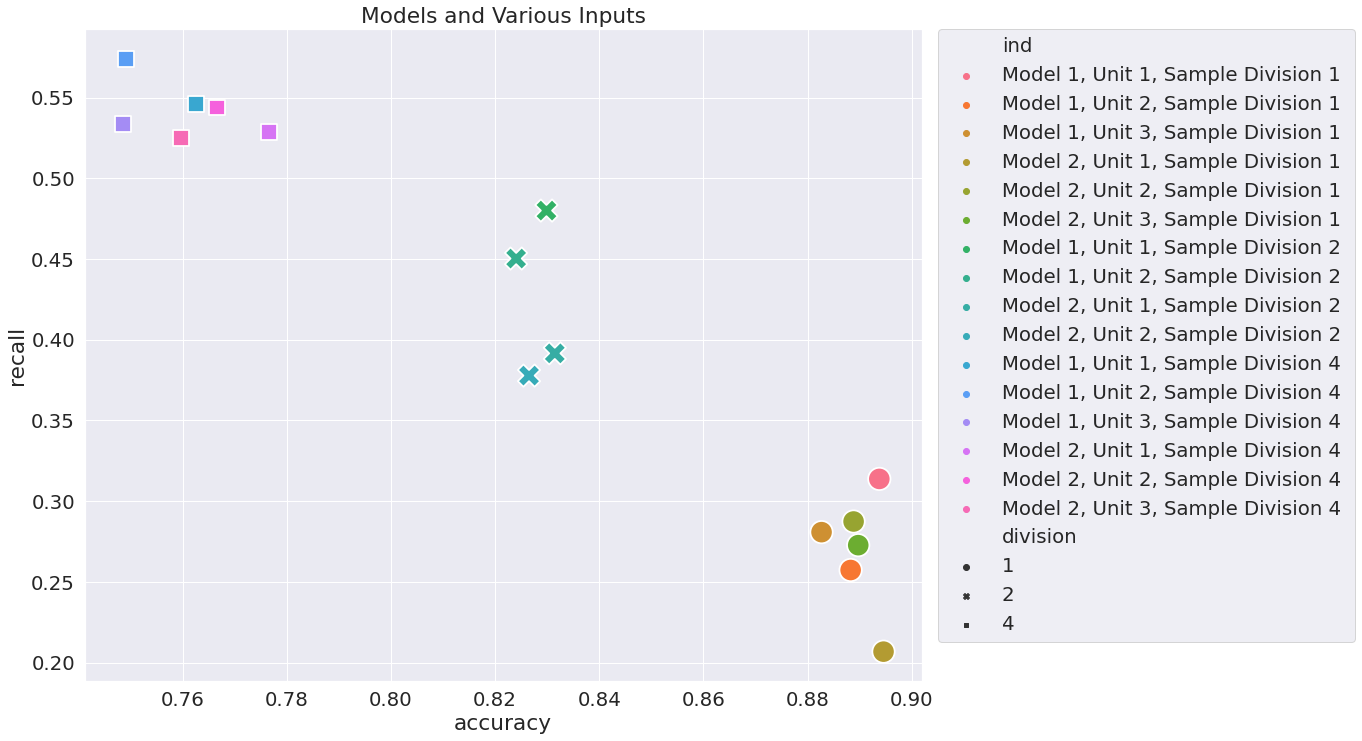

In [207]:
# [model,unit_multi,traiing_adj]
design_matrix=[[1,1,1],[1,2,1],[1,3,1],[2,1,1],[2,2,1],[2,3,1],[1,1,2],[1,2,2],[2,1,2],[2,2,2],[1,1,4],[1,2,4],[1,3,4],
               [2,1,4],[2,2,4],[2,3,4]]
labels = []
accuracy = []
recall = []
division=[]
for dm in design_matrix:
    (model,history,predictions,y_test)=train_model(df=df, 
                            verbose=0, epochs=30, units_multiplier=dm[1], model_sel=dm[0],training_adj_factor=dm[2])
    output = calc_metrics(model,predictions,y_test)
    labels.append(f"Model {str(dm[0])}, Unit {str(dm[1])}, Sample Division {str(dm[2])} ")
    accuracy.append(output[0])
    recall.append(output[1])
    division.append(str(dm[2]))

chart = pd.DataFrame({"ind":labels, "accuracy":accuracy, "recall":recall, "division":division})

plt.figure(figsize = (15,12))
sns.scatterplot(data=chart, x='accuracy',y='recall',hue='ind',style='division',s=500)
plt.title("Models and Various Inputs")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [208]:
chart

,ind,accuracy,recall,division
0,"Model 1, Unit 1, Sample Division 1",0.893774,0.313783,1
1,"Model 1, Unit 2, Sample Division 1",0.888268,0.257331,1
2,"Model 1, Unit 3, Sample Division 1",0.882682,0.280792,1
3,"Model 2, Unit 1, Sample Division 1",0.894583,0.206745,1
4,"Model 2, Unit 2, Sample Division 1",0.888835,0.287390,1
5,"Model 2, Unit 3, Sample Division 1",0.889726,0.272727,1
6,"Model 1, Unit 1, Sample Division 2",0.829865,0.480058,2
7,"Model 1, Unit 2, Sample Division 2",0.824043,0.450326,2
8,"Model 2, Unit 1, Sample Division 2",0.831466,0.391588,2
9,"Model 2, Unit 2, Sample Division 2",0.826517,0.377810,2


# Final Model

Based on the observation above and a few more attempts, I would choose this model (model 1 with 2x units, 40 epochs) as the final model for this project. It shows a sign of overfitting and the accuracy rate slightly got worse, it achieved a good balance of recall rate for yes/no response. 37% of recall rate is a significant improvement from the supervised models.

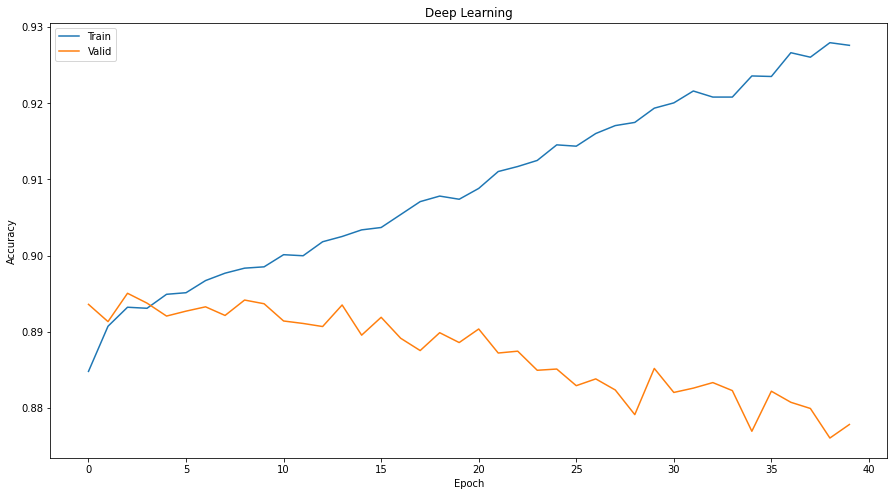

-----------------Deep Learning---------------
Classification Report

              precision    recall  f1-score   support

           0       0.92      0.94      0.93     10993
           1       0.44      0.37      0.40      1364

    accuracy                           0.88     12357
   macro avg       0.68      0.65      0.66     12357
weighted avg       0.87      0.88      0.87     12357

Confusion Matrix

[[10348   645]
 [  865   499]]

accuracy score 0.8778020555150926


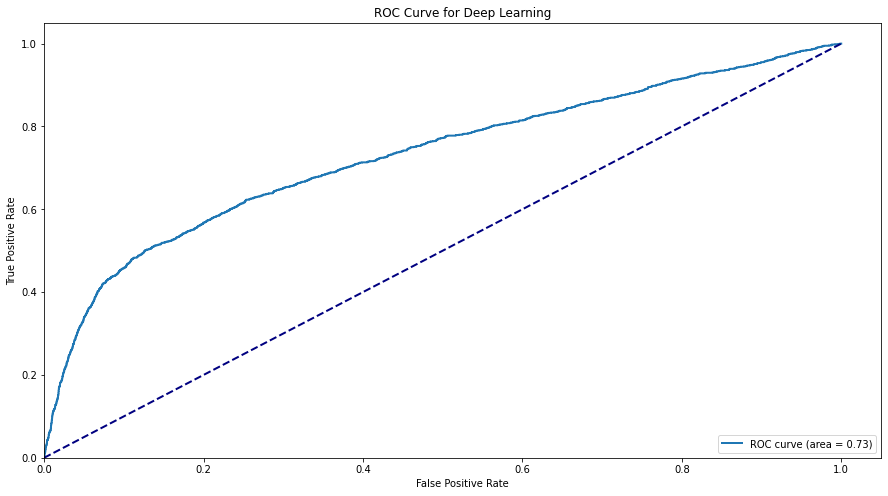

In [16]:
(model, history, predictions,y_test) = train_model(df=df, verbose=0, epochs=40, units_multiplier=2, model_sel=1, training_adj_factor=1)
# This is the best. Keep it.
plt.figure(figsize = (15,8))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Train", "Valid"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Deep Learning")
plt.show()

pred_bin = predictions.round().astype(int)
classification_printout("Deep Learning",y_test,pred_bin,predictions)

## Discussion and Conclusions
Deep learning models showed better performance with less human interventions. I found this promising and got a sense of why people are actively adopting deep learning recently. It has the potential to higher predictivity and automated model development.

In the data used in this project, none of the predictors showed a strong correlation with the response. All of them has a correlation with a magnitude of less 0.3.  To extract predictiveness, we would need to leverage higher degrees and interactions between features with the traditional model. Deep learning models were able to capture these characteristics without requiring additional efforts on developers’ end, which I also found attractive.

At the same time, the challenge of expandability was apparent. It is very difficult to provide the justification and explanation why the model is working. It would be more difficult to assess how the model reacts to the data changes. One solution could be to keep refreshing the models often using automation. However, that required rigorous “model risk” control. Trying many and picking models that work may be fine with marketing models like the ones in this project, but we should not take such an approach in a regulated areas or mission critical areas. 
I should give more consideration to the expandability in future projects. 
